# Práctica 4: Bagging y Pasting

Inteligencia de Datos

Universidad Iberoamericana Ciudad de México

Creado por: Luis Norberto Zúñiga Morales, inspirado en el libro *Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow*.

## Bagging y Pasting en Scikit-Learn

Scikit-Learn ofrece una API relativamente simple para implementar Bagging y Pasting mediante la clase `BaggingClassifier` o `BaggingRegressor`. El siguiente código entrena un ensamble de 500 Árboles de Decisión para clasificación: ada uno se entra con 100 instancias seleccionadas aleatoriamente del conjunto de entrenamiento con reemplazo (es decir, Bagging). Si quisieramos Pasting, pasamos el parámetro `bootstrap = False`.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Creamos los datos con la función `make_moons` y creamos los conjuntos de entrenamiento y prueba.

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Creamos el ensamble descrito al inicio. Noten que `BaggingClassifier` ejecuta voto suave is el clasificador base puede estimar probabilidades para cada clase, que es el caso de  los Árboles de Decisión.

In [3]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Ya entrenado el modelo, vamos a determinar el rendimiento del ensamble contra el de un simple Árbol de Decisión:

In [4]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [5]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Como pueden apreciar, el ensamble mejoró notablemente el rendimiento al clasificar los datos. La siguiente figura explora los márgenes de decisión que crean el Árbol en solitario contra el ensamble que emplea Bagging. Como pueden observar, las predicciones que realiza el ensamble parecen generalizar mejor los datos. Aún más, parece que mantiene el mismo sesgo pero con una menor varianza (realizar, más o menos, el mismo número de errores en el conjunto de entrenamiento, pero el márgen de decisión es mejor irregular).

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [7]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

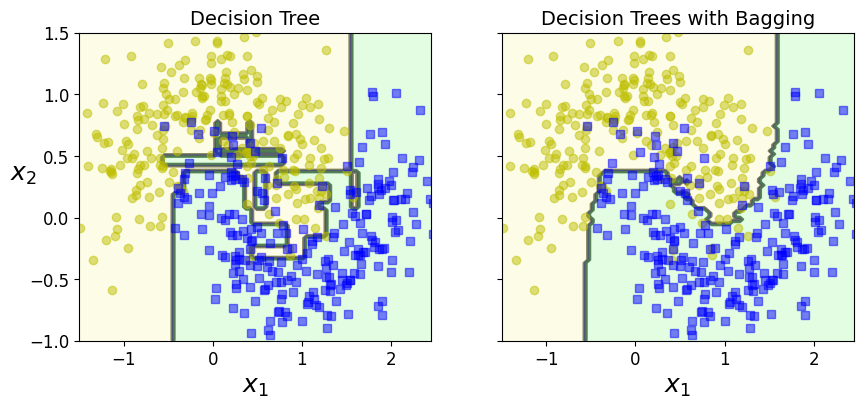

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

Aplicar Bootstrap introduce un poco más de diversidad en los subconjuntos que cada predictor utiliza para entrenarse, por lo que los modelos con Bagging terminan con un poco más de sesgo comparados con Pasting, pero esto ocasiona que la varianza disminuya (ya que hay menos correlación entre los datos). En general, Bagging tiende a dar mejores resultados, pero no está de más comparar ambos y decidir cual es el mejor.

## Evaluación en el conjunto Out-of-Bag

Al aplicar Bagging, algunas instancias durante el muestreo no serán elegidas. Por default, un `BaggingClassifier` muestrea $m$  instancias de entrenamiento con reemplazo, donde $m$ es el tamaño del conjunto de entrenamiento. Como se mencionó en la otra clase, esto provoca que cerca del 63% de las instancias de entrenamiento sean seleccionadas en promedio para cada predictor. El restante 37% que no lo son se conocen como instancias *out-of-bag* (oob). Noten que no son las mismas 37% para todos los modelos base.

Un modelo de Bagging puede ser evaluado usando las intancias oob, lo que elimina la necesidad de un conjunto de validación. En Scikit-Learn es posbile usar el parámetro `oob_score` con `True` para que realice una evaluación oob después de entrenarse.

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

En base a esta evaluación con el conjunto oob, el ensamble de Bagging probablemente obtenga cerca del 89.86% de precisión (o accuracy) en el conjunto de prueba. Vamos a verificarlo:

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

¡Bastante cerca!

La función de decisión para el oob de cada instrancia de entrenamiento se encuentra disponible mediante la variable `oob_decision_function_`. En nuestro caso, la función de decisión regrea una probabilidad de clase para cada instancia de entrenamiento. Por ejemplo, la evaluación con oob estima que la primer instancia tiene un 67.72% de pertenecer a la clase positiva y un 32.27% de pertenecer a la clase negativa.

In [ ]:
bag_clf.oob_decision_function_

## Ejercicios

1. Buscar la documentación de la clase `BaggingClassifier`de Scikit-Learn y explicar que hacen los primeros siete parámetros de esta. ¿Son los mismos para `BaggingRegressor`?

2. Usando el mismo conjunto de datos de esta práctica, vamos a medir el impacto que ocasiona el número de modelos base en la métrica de evaluación. Entrenen un `BaggingClassifier` con el número de estimadores base entre 10 y 1000. Graficar los resultados en un gráfico `n_estimators` vs `accuracy_score`. Como modelo base usen un Árbol de Decisión con profundida máxima de 1. Escribir sus conclusiones.